In [1]:
import sys
sys.path.append('../')

import torch as tc
import numpy as np
import matplotlib.pyplot as plt

import gpytorch

from rcgp.experimental import SpatioTemporalRCGP
from rcgp.kernels import Matern32Kernel

from rcgp.weight_functions import IMQ, partial_y_IMQ

/opt/miniconda3/envs/RTGP/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def generate_data(lengthscale=0.4, magnitude=2., var_y = 0.02, seed=42):
    tc.manual_seed(seed)  # For reproducibility

    x = tc.linspace(0, 1, 100)  # Same points for training and testing
    # Define known kernel parameters
    kernel = Matern32Kernel(lengthscale=tc.tensor(lengthscale), magnitude=tc.tensor(magnitude))

    cov_matrix = kernel.forward(x.reshape(-1,1), x.reshape(-1,1)) + 1e-5 * tc.eye(len(x))
    mean = tc.zeros(x.shape)

    true_f = tc.distributions.MultivariateNormal(mean, cov_matrix).sample()
    true_f = true_f - true_f.mean()

    noise = tc.distributions.Normal(0, var_y).sample(true_f.shape)

    y = true_f + noise

    return x, y, true_f

In [3]:
def rcgp(var_y, magnitude, lengthscale, grid, Ys, return_std=True):

    with tc.no_grad():
        matern_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=3/2))
        matern_kernel.base_kernel.lengthscale = tc.tensor(lengthscale)
        matern_kernel.outputscale = tc.tensor(magnitude)
        K = matern_kernel.forward(grid.reshape(-1,1), grid.reshape(-1,1))

    m = tc.zeros_like(Ys, dtype=tc.float32) + Ys.mean()

    beta= np.sqrt(var_y / 2)
    c= 1.
    
    w = IMQ(Y=Ys, m=m, beta=beta, c=c)
    partial_w = partial_y_IMQ(Y=Ys, m=m, beta=beta, c=c)

    J_w = tc.diag((var_y / 2) * w.flatten()**(-2))

    m_w = m + 2 * var_y * (w)**(-1) * partial_w

    A = tc.linalg.inv(K + var_y * J_w)

    mu_rcgp = m + K @ A @ (Ys - m_w)

    if return_std:
        Sigma = K @ A @ (var_y * J_w)
        std_rcgp = tc.sqrt(tc.diag(Sigma))
    
        return mu_rcgp.flatten(), std_rcgp

    else:
        return mu_rcgp.flatten()

In [22]:
def run(true_lengthscale=0.2, true_magnitude=2, true_var_y=0.25, seed=42):

    Xs, Ys, true_func = generate_data(lengthscale=true_lengthscale, magnitude=true_magnitude, var_y=true_var_y, seed=seed)

    st_rcgp = SpatioTemporalRCGP(ts=Xs.reshape(-1,1), grid=None, Ys=Ys.reshape(-1,1), p=1)

    st_rcgp.var_y = true_var_y
    st_rcgp.temporal_lengthscale = true_lengthscale
    st_rcgp.temporal_magnitude = true_magnitude

    with tc.no_grad():
        st_rcgp.activate_robustness(func='constant') #Weight function = Ys.mean()
        st_rcgp.c = 1. #Fixing c

        (pred_st_rcgp_robust, std_st_rcgp_robust, _), _, _  = st_rcgp.forward()
        pred_st_rcgp_robust = pred_st_rcgp_robust.squeeze()
        std_st_rcgp_robust = std_st_rcgp_robust.squeeze()

    pred_rcgp, std_rcgp = rcgp(var_y=true_var_y,
                            magnitude=true_magnitude,
                            lengthscale=true_lengthscale,
                            grid=Xs.reshape(-1,1),
                            Ys=Ys.reshape(-1,1))
    
    return (pred_st_rcgp_robust, std_st_rcgp_robust), (pred_rcgp, std_rcgp), Xs, Ys


def compare(true_lengthscale=0.2, true_magnitude=2, true_var_y=0.25, seed=42):
    (pred_st_rcgp_robust, std_st_rcgp_robust), (pred_rcgp, std_rcgp), Xs, Ys = run(true_lengthscale, true_magnitude, true_var_y, seed)

    diff_pred = np.abs((pred_rcgp - pred_st_rcgp_robust) / pred_rcgp) * 100

    return diff_pred.mean(), np.abs(std_st_rcgp_robust - std_rcgp).max(), Ys


def plot(true_lengthscale=0.2, true_magnitude=2, true_var_y=0.25, seed=42):
    (pred_st_rcgp_robust, std_st_rcgp_robust), (pred_rcgp, std_rcgp), Xs, Ys = run(true_lengthscale, true_magnitude, true_var_y, seed)

    plt.figure(figsize=(14, 8))

    #Data and True Function
    plt.plot(Xs.numpy(), Ys.numpy(), 'k.', label='Data')

    #ST-RCGP
    plt.plot(Xs.numpy(), pred_st_rcgp_robust.squeeze().numpy(), color='green', label='ST-RCGP')
    plt.fill_between(Xs.numpy(), pred_st_rcgp_robust.squeeze().numpy() - 3 * std_st_rcgp_robust.squeeze().numpy(), pred_st_rcgp_robust.squeeze().numpy() + 3 * std_st_rcgp_robust.squeeze().numpy(), color='green', alpha=0.3)

    #RCGP
    plt.plot(Xs.numpy(), pred_rcgp.squeeze().numpy(), color='red', label='RCGP')
    plt.fill_between(Xs.numpy(), pred_rcgp.squeeze().numpy() - 3 * std_rcgp.squeeze().numpy(), pred_rcgp.squeeze().numpy() + 3 * std_rcgp.squeeze().numpy(), color='red', alpha=0.3)

    plt.legend(fontsize=10)
    return
    

In [17]:
lengthscale_vals = np.linspace(0.2, 3, 5)
magnitude_vals = np.linspace(2, 4, 5)
var_y_vals = np.linspace(0.2, 1, 5)

diff_means, diff_vars = [], []
for l in lengthscale_vals:
    for m in magnitude_vals:
        for var in var_y_vals:
            res = compare(l, m, var)
            if res[0] > 10:
                print(l, m, var)
            diff_means.append(res[0])
            diff_vars.append(res[1])


0.2 2.0 0.8
0.2 2.0 1.0
0.2 2.5 0.4
0.2 3.5 1.0
0.8999999999999999 2.0 0.8
0.8999999999999999 2.0 1.0
0.8999999999999999 2.5 0.8
1.5999999999999999 2.0 0.2
1.5999999999999999 2.5 0.4
1.5999999999999999 3.0 0.4
1.5999999999999999 3.0 0.6000000000000001
1.5999999999999999 3.5 0.2
1.5999999999999999 3.5 0.6000000000000001
2.3 2.0 0.4
2.3 2.0 0.6000000000000001
2.3 2.0 0.8
2.3 2.0 1.0
2.3 2.5 0.8
2.3 2.5 1.0
2.3 3.0 0.4
2.3 3.0 1.0
2.3 3.5 1.0
2.3 4.0 0.8
2.3 4.0 1.0
3.0 2.0 1.0
3.0 2.5 0.6000000000000001
3.0 2.5 0.8
3.0 3.0 0.8
3.0 3.0 1.0
3.0 3.5 1.0
3.0 4.0 1.0


(None,
 (tensor(3.3752),
  tensor(1.4603e-06),
  tensor([ 2.2526,  1.9134,  1.7091,  2.4709,  2.8839,  1.4246,  2.6997,  1.4338,
           2.3333,  1.5873,  1.7564,  1.3004,  0.2650,  0.8689, -0.1947, -0.4196,
          -0.2214,  1.1298,  0.2553,  0.1282, -0.7151, -0.5101, -0.3797,  0.3329,
          -0.4387,  0.9225, -0.2143,  1.1153,  1.0010,  0.9614, -0.0312,  0.7880,
           1.4834,  1.0406,  0.5335,  1.2019,  1.9753,  0.8087, -0.7222,  1.4442,
          -1.1020,  0.4293, -0.3396,  1.0880, -0.0437, -0.1735, -0.8333, -0.0593,
          -0.1867, -1.2216, -0.6904, -1.8397, -0.3266, -1.3984, -0.7660, -0.4383,
          -2.7447, -1.0630, -1.1818, -0.2526, -1.1390, -2.3745, -2.2375, -1.5981,
          -2.3431, -2.6603, -1.9871, -1.1794,  0.1020,  0.9888, -1.2671, -0.5774,
           1.0017, -0.1322,  0.9839,  1.0928, -0.5884,  0.1139,  0.9756,  0.9772,
          -0.6496,  0.4208,  0.3015,  0.7646,  0.5464, -0.2192,  0.2644, -0.9684,
          -0.4730,  0.7899, -0.3026, -0.3070, -0.87

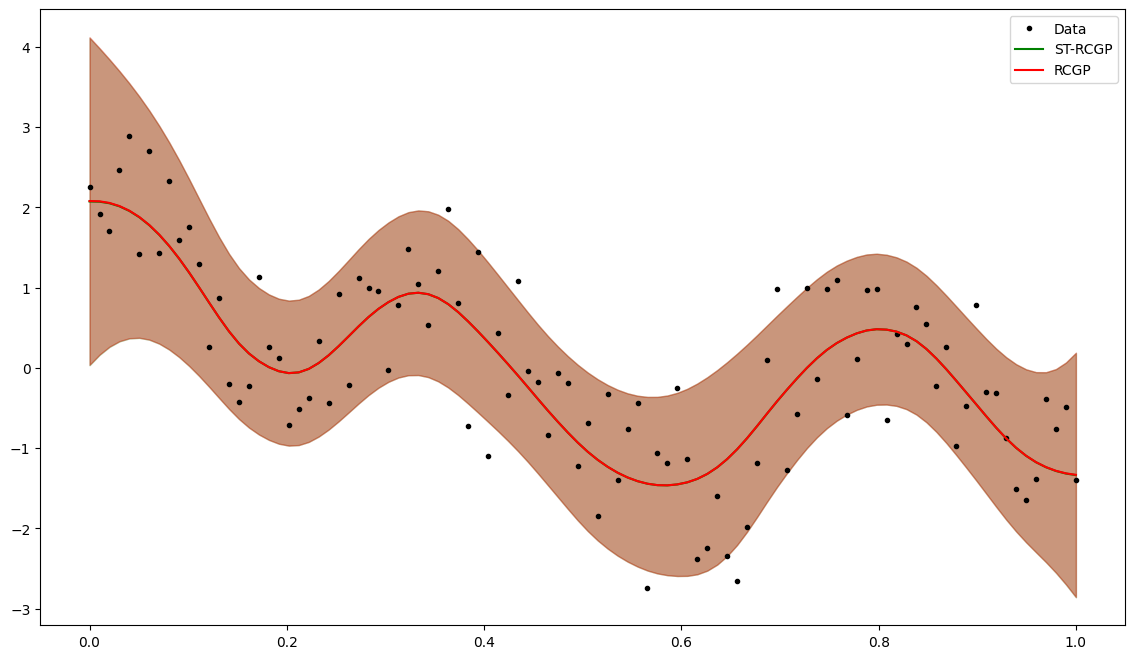

In [23]:
plot(0.2, 2.0, 0.8), compare(0.2, 2.0, 0.8)

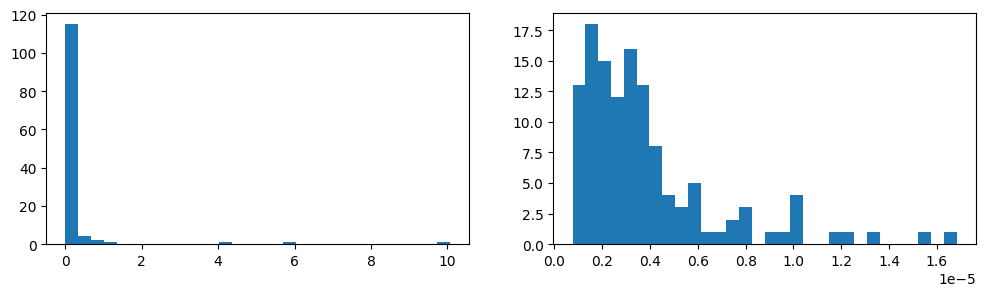

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12,3))
axs[0].hist(tc.stack(diff_means).numpy(), bins=30)
axs[1].hist(tc.stack(diff_vars).numpy(), bins=30);